In [1]:
import numpy as np
import nibabel as nib
import h5py
import pandas as pd
from scipy.ndimage.interpolation import zoom

import sys
sys.path.append("../")
from config import doc_dir, indices_holdout

/home/fabiane/anaconda2/envs/mort/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
doc_dir = "/analysis/fabiane/data/MS/explMS/file_list_HC_MS_BET_FLAIR.csv"

In [3]:
output_shape = (96, 114, 96)
z_factor=0.525

In [4]:
df = pd.read_csv(doc_dir)

In [5]:
df.head()

,file,label,name,path,time
0,VIMS_MS_027_1_FLAIR.nii.gz,MS,VIMS_MS_027,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_02...,1.0
1,VIMS_MS_043_1_FLAIR.nii.gz,MS,VIMS_MS_043,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_141_1_FLAIR.nii.gz,MS,VIMS_MS_141,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_14...,1.0
3,VIMS_MS_137_1_FLAIR.nii.gz,MS,VIMS_MS_137,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
4,VIMS_HC_022_1_FLAIR.nii.gz,HC,VIMS_HC_022,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_02...,1.0


In [6]:
# split datasets
holdout_df = df.iloc[indices_holdout]
train_df = df.drop(indices_holdout)

holdout_df.reset_index(inplace=True)
holdout_df = holdout_df.drop("index", axis="columns")
train_df.reset_index(inplace=True)
train_df = train_df.drop("index", axis="columns")

In [7]:
holdout_df.head()

,file,label,name,path,time
0,VIMS_MS_118_1_FLAIR.nii.gz,MS,VIMS_MS_118,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_11...,1.0
1,VIMS_MS_041_1_FLAIR.nii.gz,MS,VIMS_MS_041,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_132_1_FLAIR.nii.gz,MS,VIMS_MS_132,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
3,RS_GK_002_1_FLAIR.nii.gz,HC,RS_GK_002,/analysis/share/Ritter/MS/CIS/02_HC/RS_GK_002/...,1.0
4,VIMS_MS_073_1_FLAIR.nii.gz,MS,VIMS_MS_073,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_07...,1.0


In [8]:
train_df.head()

,file,label,name,path,time
0,VIMS_MS_027_1_FLAIR.nii.gz,MS,VIMS_MS_027,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_02...,1.0
1,VIMS_MS_043_1_FLAIR.nii.gz,MS,VIMS_MS_043,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_141_1_FLAIR.nii.gz,MS,VIMS_MS_141,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_14...,1.0
3,VIMS_MS_137_1_FLAIR.nii.gz,MS,VIMS_MS_137,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
4,VIMS_HC_022_1_FLAIR.nii.gz,HC,VIMS_HC_022,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_02...,1.0


In [9]:
print(len(train_df))
print(len(holdout_df))

124
23


In [10]:
(len(train_df), ) + output_shape

(124, 96, 114, 96)

In [11]:
output_shape = (182, 218, 182) 

(96, 114, 96)

In [16]:
# load images in matrix
def create_dataset(dataset, z_factor, output_shape):
    data_matrix = np.empty(shape=((len(dataset),) + output_shape))
    labels = np.empty(shape=((len(dataset),)))
    for idx, row in dataset.iterrows():
        path = row["path"]
        # switch to mprage
        path = path.replace("FLAIR", "MPRAGE")
        path = path.replace("/Ritter/MS", "/Ritter/Dataset/MS")
        path = path.replace(".nii.gz", ".nii")
        GM_path = path.replace("BET_", "c1")
        WM_path = path.replace("BET_", "c2")
        CSF_path = path.replace("BET_", "c3")
        
        # in case of no lesion mask fill with random values
        try:
            GM = nib.load(GM_path).get_data().astype(np.float32)
            WM = nib.load(WM_path).get_data().astype(np.float32)
            CSF = nib.load(CSF_path).get_data().astype(np.float32)
            mask = np.zeros_like(GM)
            mask[np.where(np.logical_or(np.greater(WM, CSF), np.greater(GM, CSF)))] = 1
            #struct_arr = zoom(mask, z_factor, order=0) #order 0 = NN interpolation
            struct_arr = mask
        except(FileNotFoundError):
            print("File not Found: {}".format(path))
            struct_arr = np.random.rand(output_shape[0], output_shape[1], output_shape[2])
        data_matrix[idx] = struct_arr
        labels[idx] = (row["label"] == "MS") *1
    return data_matrix, labels

In [17]:
train_dataset, train_labels = create_dataset(train_df, z_factor=z_factor, output_shape=output_shape)
holdout_dataset, holdout_labels = create_dataset(holdout_df, z_factor=z_factor, output_shape=output_shape)

File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_027/VIMS_MS_027_1/BET_VIMS_MS_027_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_043/VIMS_MS_043_1/BET_VIMS_MS_043_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_141/VIMS_MS_141_1/BET_VIMS_MS_141_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_137/VIMS_MS_137_1/BET_VIMS_MS_137_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/VIMS_HC_022/VIMS_HC_022_1/BET_VIMS_HC_022_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/RS_GK_021/RS_GK_021_1/BET_RS_GK_021_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_088/VIMS_MS_088_1/BET_VIMS_MS_088_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/VIMS_HC_045/VIMS_HC_045_1/BET_VIMS_HC_045_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_071/VIMS_MS_071_1/

File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/RS_GK_029/RS_GK_029_1/BET_RS_GK_029_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_104/VIMS_MS_104_1/BET_VIMS_MS_104_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/RS_GK_022/RS_GK_022_1/BET_RS_GK_022_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_131/VIMS_MS_131_1/BET_VIMS_MS_131_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_138/VIMS_MS_138_1/BET_VIMS_MS_138_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_090/VIMS_MS_090_1/BET_VIMS_MS_090_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/02_HC/VIMS_HC_091/VIMS_HC_091_1/BET_VIMS_HC_091_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_020/VIMS_MS_020_1/BET_VIMS_MS_020_1_MPRAGE.nii
File not Found: /analysis/share/Ritter/Dataset/MS/CIS/03_MS/VIMS_MS_124/VIMS_MS_124_1/BET_VI

In [13]:
print(train_dataset.shape)
print(holdout_dataset.shape)

(124, 96, 114, 96)
(23, 96, 114, 96)


In [14]:
import matplotlib.pyplot as plt

In [15]:
train_df.iloc[-1]

file                            VIMS_HC_030_1_FLAIR.nii.gz
label                                                   HC
name                                           VIMS_HC_030
path     /analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_03...
time                                                     1
Name: 123, dtype: object

In [16]:
train_dataset[-1].max()

0.0

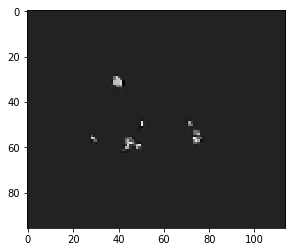

In [17]:
plt.imshow(train_dataset[-2][:,:,48], cmap='gray')
plt.show()

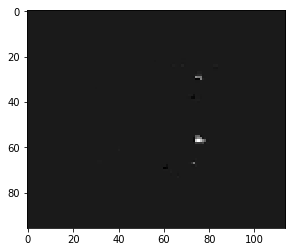

In [18]:
plt.imshow(holdout_dataset[-1][:,:,48], cmap='gray')
plt.show()

In [19]:
h5 = h5py.File('/data/Ritter/MS/CIS/train_dataset_brain_masks.h5', 'w')
h5.create_dataset('masks', data=train_dataset)
h5.close()

In [20]:
h5 = h5py.File('/data/Ritter/MS/CIS/holdout_dataset_brain_masks.h5', 'w')
h5.create_dataset('masks', data=holdout_dataset)
h5.close()